# Effective Dimension of Qiskit Neural Networks
In this tutorial, we will take advantage of the `EffectiveDimension` and `LocalEffectiveDimension` classes to evaluate the power of Quantum Neural Network models. These are metrics based on information geometry that connect to notions such as trainability, expressibility or ability to generalize.

Before diving into the code example, we will briefly explain what is the difference between these two metrics, and why are they relevant to the study of Quantum Neural Networks. More information about global effective dimension can be found in [this paper](https://arxiv.org/pdf/2011.00027.pdf), while the local effective dimension was introduced in a [later work](https://arxiv.org/abs/2112.04807).

## 1. Global vs. Local Effective Dimension
Both classical and quantum machine learning models share a common goal: being good at **generalizing**, i.e. learning insights from data and applying them on unseen data.

Finding a good metric to assess this ability is a non-trivial matter. In [The Power of Quantum Neural Networks](https://arxiv.org/pdf/2011.00027.pdf), the authors introduce the **global** effective dimension as a useful indicator of how well a particular model will be able to perform on new data. In [Effective Dimension of Machine Learning Models](https://arxiv.org/pdf/2112.04807.pdf), the **local** effective dimension is proposed as a new capacity measure that bounds the generalization error of machine learning models.

The key difference between global (`EffectiveDimension` class) and **local** effective dimension (`LocalEffectiveDimension` class) is actually not in the way they are computed, but in the nature of the parameter space that is analyzed. The global effective dimension incorporates the **full parameter space** of the model, and is calculated from a **large number of parameter (weight) sets**. On the other hand, the local effective dimension focuses on how well the **trained** model can generalize to new data, and how **expressive** it can be. Therefore, the local effective dimension is calculated from **a single** set of weight samples (training result). This difference is small in terms of practical implementation, but quite relevant at a conceptual level.

## 2. The Effective Dimension Algorithm

Both the global and local effective dimension algorithms use the Fisher Information matrix to provide a measure of complexity. The details on how this matrix is calculated are provided in the [reference paper](https://arxiv.org/pdf/2011.00027.pdf), but in general terms, this matrix captures how sensitive a neural network's output is to changes in the network's parameter space.

In particular, this algorithm follows 4 main steps:

1. **Monte Carlo simulation:** the forward and backward passes (gradients) of the neural network are computed for each pair of input and weight samples.
2. **Fisher Matrix Computation:** these outputs and gradients are used to compute the Fisher Information Matrix.
3. **Fisher Matrix Normalization:** averaging over all input samples and dividing by the matrix trace
4. **Effective Dimension Calculation:** according to the formula from [*Abbas et al.*](https://arxiv.org/pdf/2011.00027.pdf)

## 3. Basic Example (SamplerQNN)

This example shows how to set up a QNN model problem and run the global effective dimension algorithm. Both Qiskit `SamplerQNN` (shown in this example) and `EstimatorQNN` (shown in a later example) can be used with the `EffectiveDimension` class.

We start off from the required imports and a fixed seed for the random number generator for reproducibility purposes.

In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.primitives import StatevectorSampler as Sampler, StatevectorEstimator as Estimator

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# set random seed
algorithm_globals.random_seed = 42
sampler = Sampler()
estimator = Estimator()

### 3.1 Define QNN

The first step to create a `SamplerQNN` is to define a parametrized feature map and ansatz. In this toy example, we will use 3 qubits and the `QNNCircuit` class to simplify the composition of a feature map and an ansatz circuit. The resulting circuit is then used in the `SamplerQNN` class.

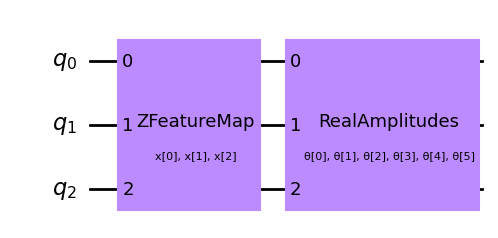

In [2]:
num_qubits = 3
# combine a custom feature map and ansatz into a single circuit
qc = QNNCircuit(
    feature_map=ZFeatureMap(feature_dimension=num_qubits, reps=1),
    ansatz=RealAmplitudes(num_qubits, reps=1),
)
qc.draw(output="mpl", style="clifford")

The parametrized circuit can then be sent together with an optional interpret map (parity in this case) to the `SamplerQNN` constructor.

In [3]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [4]:
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


### 3.2 Set up Effective Dimension calculation

In order to compute the effective dimension of our QNN using the `EffectiveDimension` class, we need a series of sets of input samples and weights, as well as the total number of data samples available in a dataset. The `input_samples` and `weight_samples` are set in the class constructor, while the number of data samples is given during the call to the effective dimension computation, to be able to test and compare how this measure changes with different dataset sizes.

We can define the number of input samples and weight samples and the class will randomly sample a corresponding array from a normal (for `input_samples`) or a uniform (for `weight_samples`) distribution. Instead of passing a number of samples we can pass an array, sampled manually.

In [5]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

If we want to test a specific set of input samples and weight samples, we can provide it directly to the `EffectiveDimension` class as shown in the following snippet:

In [6]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

The effective dimension algorithm also requires a dataset size. In this example, we will define an array of sizes to later see how this input affects the result.

In [7]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

### 3.3 Compute Global Effective Dimension
Let's now calculate the effective dimension of our network for the previously defined set of input samples, weights, and a dataset size of 5000.

In [8]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

The effective dimension values will range between 0 and `d`, where `d` represents the dimension of the model, and it's practically obtained from the number of weights of the QNN. By dividing the result by `d`, we can obtain the normalized effective dimension, which correlates directly with the capacity of the model.

In [9]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.6963
Number of weights: 6, normalized effective dimension: 0.7827


By calling the `EffectiveDimension` class with an array if input sizes `n`, we can monitor how the effective dimension changes with the dataset size.

In [10]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

In [11]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.72156755 4.77703036 4.80475408 4.97821692 5.02553589 5.08148127
 5.12278374 5.15041419 5.22959011 5.2813772 ]
Number of weights: 6


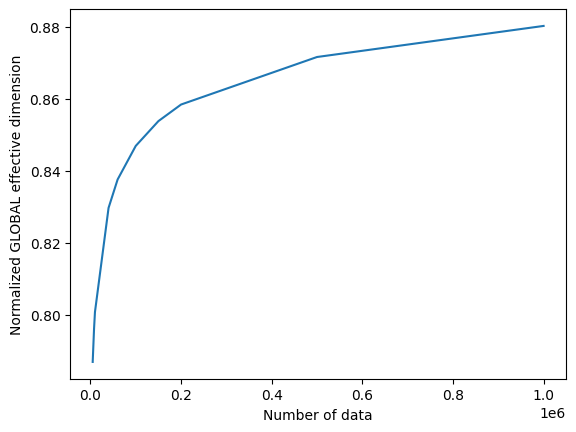

In [12]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

## 4. Local Effective Dimension Example
As explained in the introduction, the local effective dimension algorithm only uses **one** set of weights, and it can be used to monitor how training affects the expressiveness of a neural network. The `LocalEffectiveDimension` class enforces this constraint to ensure that these calculations are conceptually separate, but the rest of the implementation is shared with `EffectiveDimension`.

This example shows how to leverage the `LocalEffectiveDimension` class to analyze the effect of training on QNN expressiveness.

### 4.1 Define Dataset and QNN

We start by creating a 3D binary classification dataset using `make_classification` function from scikit-learn.

In [13]:
num_inputs = 3
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

The next step is to create a QNN, an instance of `EstimatorQNN` in our case in the same fashion we created an instance of `SamplerQNN`.

In [14]:
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


### 4.2 Train QNN

We can now proceed to train the QNN. The training step may take some time, be patient. You can pass a callback to the classifier to observe how the training process is going on. We fix `initial_point` for reproducibility purposes as usual.

In [15]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=80),
    initial_point=initial_point,
    callback=callback_graph,
)

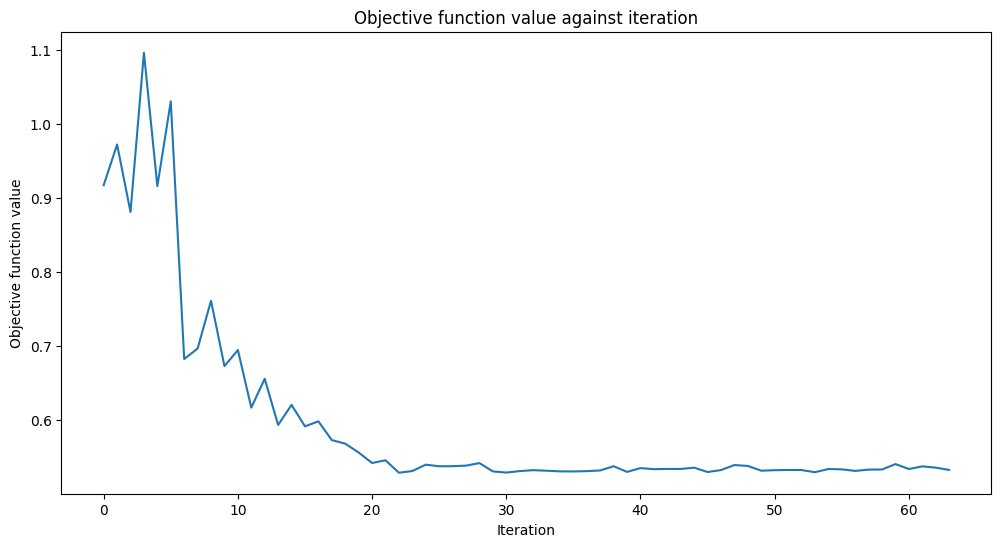

In [17]:
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

The classifier can now differentiate between classes with an accuracy of:

In [18]:
# score classifier
estimator_classifier.score(X, y)

0.94

### 4.3 Compute Local Effective Dimension of trained QNN

Now that we have trained our network, let's evaluate the local effective dimension based on the trained weights. To do that we access the trained weights directly from the classifier.

In [19]:
trained_weights = estimator_classifier.weights

# get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=trained_weights, input_samples=X
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for trained QNN: ",
    local_eff_dim_trained / estimator_qnn.num_weights,
)

normalized local effective dimensions for trained QNN:  [0.57958596 0.59603188 0.60400038 0.65355208 0.66759979 0.684729
 0.69775701 0.7066478  0.73280229 0.75033353]


### 4.4 Compute Local Effective Dimension of untrained QNN

We can compare this result with the effective dimension of the untrained network, using the `initial_point` as our weight sample:

In [20]:
# get Local Effective Dimension for set of untrained weights
local_ed_untrained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=initial_point, input_samples=X
)

local_eff_dim_untrained = local_ed_untrained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for untrained QNN: ",
    local_eff_dim_untrained / estimator_qnn.num_weights,
)

normalized local effective dimensions for untrained QNN:  [0.73339923 0.74377359 0.74900312 0.78285996 0.79246524 0.8039964
 0.81260996 0.81841079 0.83515928 0.84618238]


### 4.5 Plot and analyze results

If we plot the effective dimension values before and after training, we can see the following result:

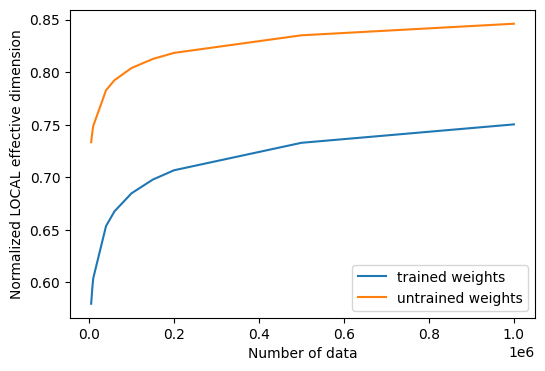

In [21]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(local_eff_dim_trained) / estimator_qnn.num_weights, label="trained weights")
plt.plot(
    n, np.array(local_eff_dim_untrained) / estimator_qnn.num_weights, label="untrained weights"
)

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.show()

In general, we should expect the value of the local effective dimension to decrease after training. This can be understood by looking back into the main goal of machine learning, which is to pick a model that is expressive enough to fit your data, but not too expressive that it overfits and performs badly on new data samples.  

Certain optimizers help regularize the overfitting of a model by learning parameters, and this action of learning inherently reduces a model’s expressiveness, as measured by the local effective dimension. Following this logic, a randomly initialized parameter set will most likely produce a higher effective dimension that the final set of trained weights, because that model with that particular parameterization is “using more parameters” unnecessarily to fit the data. After training (with the implicit regularization), a trained model will not need to use so many parameters and thus have more “inactive parameters” and a lower effective dimension. 

We must keep in mind though that this is the general intuition, and there might be cases where a randomly selected set of weights happens to provide a lower effective dimension than the trained weights for a specific model. 

In [22]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright